In [15]:
# Customer Churn Prediction - Fixed Training Pipeline with Visualizations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve, confusion_matrix)
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import joblib

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)



In [16]:
# ============================================================================
# 1️⃣ LOAD DATASET
# ============================================================================

df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

print("\n✅ Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())


✅ Dataset loaded successfully!
Dataset shape: (7043, 21)

First few rows:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...         

In [17]:
# ============================================================================
# 2️⃣ DATA PREPROCESSING
# ============================================================================

# Check for missing values
print("\n📊 Missing Values:")
print(df.isnull().sum())

# Handle TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Drop customerID
if 'customerID' in df.columns:
    df.drop('customerID', axis=1, inplace=True)

# Convert target variable
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

print("\n✅ Basic preprocessing completed!")
print(f"Dataset shape after preprocessing: {df.shape}")


📊 Missing Values:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

✅ Basic preprocessing completed!
Dataset shape after preprocessing: (7043, 20)


In [18]:
# ============================================================================
# 3️⃣ EXPLORATORY DATA ANALYSIS (EDA)
# ============================================================================

# Churn distribution
print("\n📊 Churn Distribution:")
print(df['Churn'].value_counts())
print(f"\nChurn Rate: {df['Churn'].mean()*100:.2f}%")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Churn distribution
df['Churn'].value_counts().plot(kind='bar', ax=axes[0, 0], color=['green', 'red'])
axes[0, 0].set_title('Churn Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Churn (0=No, 1=Yes)')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_xticklabels(['No Churn', 'Churn'], rotation=0)

# 2. Churn by Contract Type
if 'Contract' in df.columns:
    pd.crosstab(df['Contract'], df['Churn'], normalize='index').plot(
        kind='bar', ax=axes[0, 1], color=['green', 'red']
    )
    axes[0, 1].set_title('Churn Rate by Contract Type', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Contract Type')
    axes[0, 1].set_ylabel('Proportion')
    axes[0, 1].legend(['No Churn', 'Churn'])
    axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45)

# 3. Monthly Charges distribution by Churn
df.boxplot(column='MonthlyCharges', by='Churn', ax=axes[1, 0])
axes[1, 0].set_title('Monthly Charges by Churn', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Churn (0=No, 1=Yes)')
axes[1, 0].set_ylabel('Monthly Charges ($)')
plt.sca(axes[1, 0])
plt.xticks([1, 2], ['No Churn', 'Churn'])

# 4. Tenure distribution by Churn
df.boxplot(column='tenure', by='Churn', ax=axes[1, 1])
axes[1, 1].set_title('Tenure by Churn', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Churn (0=No, 1=Yes)')
axes[1, 1].set_ylabel('Tenure (months)')
plt.sca(axes[1, 1])
plt.xticks([1, 2], ['No Churn', 'Churn'])

plt.tight_layout()
plt.savefig('eda_visualizations.png', dpi=300, bbox_inches='tight')
print("\n✅ EDA visualizations saved as 'eda_visualizations.png'")
plt.close()

# Key Insights
print("\n" + "=" * 80)
print("📌 KEY INSIGHTS FROM EDA:")
print("=" * 80)
if 'Contract' in df.columns:
    print("1. Contract Type Impact:")
    print(pd.crosstab(df['Contract'], df['Churn'], normalize='index'))
print(f"\n2. Average Monthly Charges:")
print(f"   - Churned customers: ${df[df['Churn']==1]['MonthlyCharges'].mean():.2f}")
print(f"   - Retained customers: ${df[df['Churn']==0]['MonthlyCharges'].mean():.2f}")
print(f"\n3. Average Tenure:")
print(f"   - Churned customers: {df[df['Churn']==1]['tenure'].mean():.1f} months")
print(f"   - Retained customers: {df[df['Churn']==0]['tenure'].mean():.1f} months")


📊 Churn Distribution:
Churn
0    5174
1    1869
Name: count, dtype: int64

Churn Rate: 26.54%

✅ EDA visualizations saved as 'eda_visualizations.png'

📌 KEY INSIGHTS FROM EDA:
1. Contract Type Impact:
Churn                  0         1
Contract                          
Month-to-month  0.572903  0.427097
One year        0.887305  0.112695
Two year        0.971681  0.028319

2. Average Monthly Charges:
   - Churned customers: $74.44
   - Retained customers: $61.27

3. Average Tenure:
   - Churned customers: 18.0 months
   - Retained customers: 37.6 months


In [19]:
# ============================================================================
# 4️⃣ FEATURE ENGINEERING
# ============================================================================


# Separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Store original column order
feature_columns = X.columns.tolist()

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\n📊 Categorical columns ({len(categorical_cols)}): {categorical_cols[:5]}...")
print(f"📊 Numerical columns ({len(numerical_cols)}): {numerical_cols}")

# CRITICAL: Save label encoders for each categorical column
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Scale numerical features
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

print("\n✅ Feature engineering completed!")
print(f"Final feature matrix shape: {X.shape}")



📊 Categorical columns (15): ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines']...
📊 Numerical columns (4): ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

✅ Feature engineering completed!
Final feature matrix shape: (7043, 19)


In [20]:
# ============================================================================
# 5️⃣ HANDLE CLASS IMBALANCE & TRAIN-TEST SPLIT
# ============================================================================

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n📊 Train set: {X_train.shape}")
print(f"📊 Test set: {X_test.shape}")
print(f"\nClass distribution in training set:")
print(y_train.value_counts())

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"\n✅ After SMOTE:")
print(f"Training set shape: {X_train_balanced.shape}")
print(f"Class distribution:")
print(pd.Series(y_train_balanced).value_counts())


📊 Train set: (5634, 19)
📊 Test set: (1409, 19)

Class distribution in training set:
Churn
0    4139
1    1495
Name: count, dtype: int64

✅ After SMOTE:
Training set shape: (8278, 19)
Class distribution:
Churn
0    4139
1    4139
Name: count, dtype: int64


In [21]:
# ============================================================================
# 6️⃣ MODEL BUILDING & EVALUATION
# ============================================================================

# Dictionary to store results
results = {}

# 1. Logistic Regression
print("\n🔹 Training Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_balanced, y_train_balanced)
lr_pred = lr_model.predict(X_test)
lr_proba = lr_model.predict_proba(X_test)[:, 1]

results['Logistic Regression'] = {
    'accuracy': accuracy_score(y_test, lr_pred),
    'precision': precision_score(y_test, lr_pred),
    'recall': recall_score(y_test, lr_pred),
    'f1': f1_score(y_test, lr_pred),
    'roc_auc': roc_auc_score(y_test, lr_proba)
}

# 2. Random Forest
print("🔹 Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_balanced, y_train_balanced)
rf_pred = rf_model.predict(X_test)
rf_proba = rf_model.predict_proba(X_test)[:, 1]

results['Random Forest'] = {
    'accuracy': accuracy_score(y_test, rf_pred),
    'precision': precision_score(y_test, rf_pred),
    'recall': recall_score(y_test, rf_pred),
    'f1': f1_score(y_test, rf_pred),
    'roc_auc': roc_auc_score(y_test, rf_proba)
}

# 3. XGBoost
print("🔹 Training XGBoost...")
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
xgb_model.fit(X_train_balanced, y_train_balanced)
xgb_pred = xgb_model.predict(X_test)
xgb_proba = xgb_model.predict_proba(X_test)[:, 1]

results['XGBoost'] = {
    'accuracy': accuracy_score(y_test, xgb_pred),
    'precision': precision_score(y_test, xgb_pred),
    'recall': recall_score(y_test, xgb_pred),
    'f1': f1_score(y_test, xgb_pred),
    'roc_auc': roc_auc_score(y_test, xgb_proba)
}

# Display results
print("\n" + "=" * 80)
print("📊 MODEL PERFORMANCE COMPARISON")
print("=" * 80)
results_df = pd.DataFrame(results).T
print(results_df.round(4))

# Find best model
best_model_name = results_df['roc_auc'].idxmax()
print(f"\n🏆 Best Model: {best_model_name} (ROC-AUC: {results_df.loc[best_model_name, 'roc_auc']:.4f})")


🔹 Training Logistic Regression...
🔹 Training Random Forest...
🔹 Training XGBoost...

📊 MODEL PERFORMANCE COMPARISON
                     accuracy  precision  recall      f1  roc_auc
Logistic Regression    0.7410     0.5079  0.7701  0.6121   0.8350
Random Forest          0.7693     0.5571  0.6390  0.5953   0.8201
XGBoost                0.7644     0.5455  0.6738  0.6029   0.8128

🏆 Best Model: Logistic Regression (ROC-AUC: 0.8350)


✅ ROC curve saved as 'roc_curves.png'


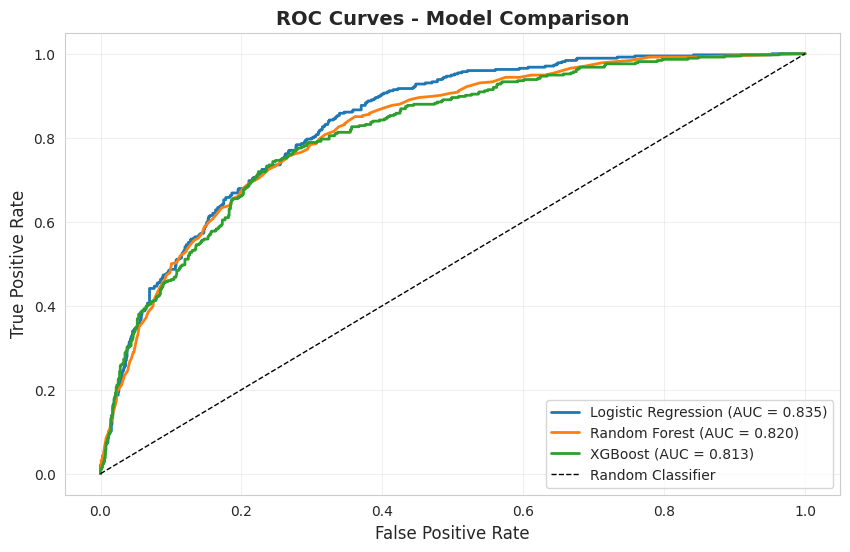

In [22]:
# ============================================================================
# 7️⃣ ROC CURVE VISUALIZATION
# ============================================================================

plt.figure(figsize=(10, 6))

# Plot ROC curves for all models
models_proba = {
    'Logistic Regression': lr_proba,
    'Random Forest': rf_proba,
    'XGBoost': xgb_proba
}

for name, proba in models_proba.items():
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc_score = roc_auc_score(y_test, proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
print("✅ ROC curve saved as 'roc_curves.png'")
plt.show()
plt.close()


✅ Feature importance plot saved as 'feature_importance.png'


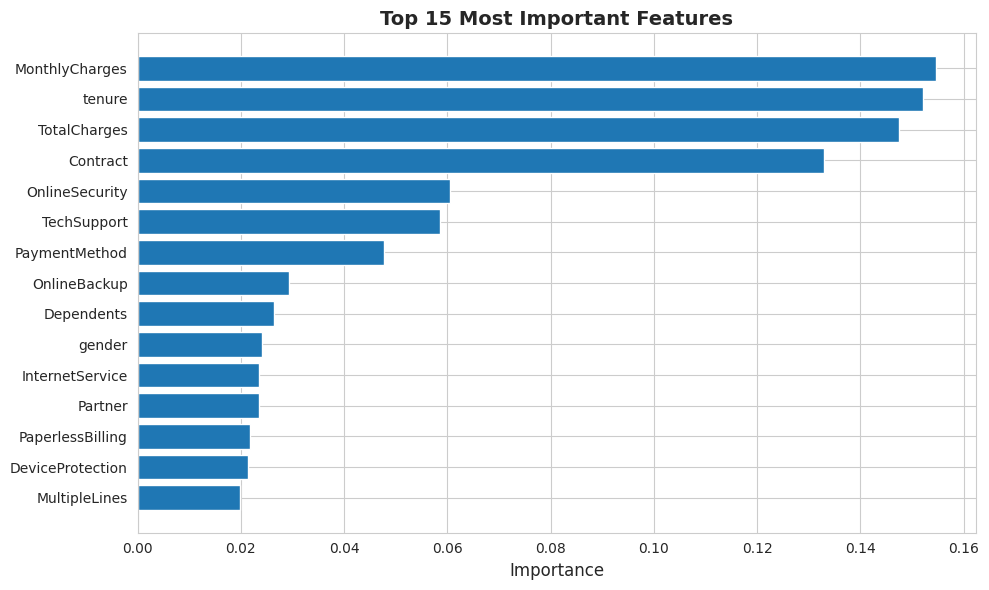


📌 Top 5 Features:
           feature  importance
17  MonthlyCharges    0.154612
4           tenure    0.152052
18    TotalCharges    0.147512
14        Contract    0.132882
8   OnlineSecurity    0.060516


In [23]:

# ============================================================================
# 8️⃣ FEATURE IMPORTANCE (BEST MODEL)
# ============================================================================

# Using Random Forest for feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance['importance'])
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Importance', fontsize=12)
plt.title('Top 15 Most Important Features', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
print("✅ Feature importance plot saved as 'feature_importance.png'")
plt.show()
plt.close()

print("\n📌 Top 5 Features:")
print(feature_importance.head())

✅ Confusion matrix saved as 'confusion_matrix.png'


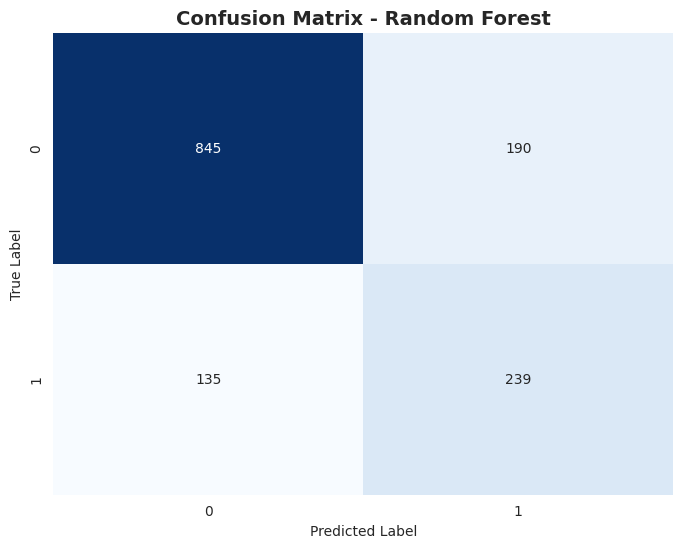

In [24]:

# ============================================================================
# 9️⃣ CONFUSION MATRIX
# ============================================================================

cm = confusion_matrix(y_test, rf_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Random Forest', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
print("✅ Confusion matrix saved as 'confusion_matrix.png'")
plt.show()
plt.close()


In [25]:
# ============================================================================
# 🎯 SAVE MODEL AND PREPROCESSING OBJECTS
# ============================================================================

joblib.dump(rf_model, 'churn_prediction_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')
joblib.dump(feature_columns, 'feature_columns.pkl')
joblib.dump({'numerical_cols': numerical_cols, 'categorical_cols': categorical_cols},
            'column_info.pkl')

print("\n✅ Model and all preprocessing objects saved successfully!")
print("\nSaved files:")
print("- churn_prediction_model.pkl")
print("- scaler.pkl")
print("- label_encoders.pkl")
print("- feature_columns.pkl")
print("- column_info.pkl")



✅ Model and all preprocessing objects saved successfully!

Saved files:
- churn_prediction_model.pkl
- scaler.pkl
- label_encoders.pkl
- feature_columns.pkl
- column_info.pkl


In [26]:
# ============================================================================
# 🎯 FINAL SUMMARY
# ============================================================================

print(f"✅ Dataset processed: {df.shape[0]} customers, {df.shape[1]-1} features")
print(f"✅ Churn rate: {df['Churn'].mean()*100:.2f}%")
print(f"✅ Best model: {best_model_name}")
print(f"✅ Model performance:")
print(f"   - Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"   - Precision: {results[best_model_name]['precision']:.4f}")
print(f"   - Recall: {results[best_model_name]['recall']:.4f}")
print(f"   - F1-Score: {results[best_model_name]['f1']:.4f}")
print(f"   - ROC-AUC: {results[best_model_name]['roc_auc']:.4f}")

print("\n📌 Business Impact:")
print(f"   - Model can identify {results[best_model_name]['recall']*100:.1f}% of churning customers")
print(f"   - Precision of {results[best_model_name]['precision']*100:.1f}% reduces false alarms")
print(f"   - This enables targeted retention campaigns")

print("\n" + "=" * 80)
print("✅ ANALYSIS COMPLETE! Ready for deployment.")
print("=" * 80)

✅ Dataset processed: 7043 customers, 19 features
✅ Churn rate: 26.54%
✅ Best model: Logistic Regression
✅ Model performance:
   - Accuracy: 0.7410
   - Precision: 0.5079
   - Recall: 0.7701
   - F1-Score: 0.6121
   - ROC-AUC: 0.8350

📌 Business Impact:
   - Model can identify 77.0% of churning customers
   - Precision of 50.8% reduces false alarms
   - This enables targeted retention campaigns

✅ ANALYSIS COMPLETE! Ready for deployment.
